# Transfer Learning With Tensorflow Part 3: Scaling up

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all the classes in Food101 (101 total of classes of food)  
see: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

## What is transfer learning ?

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem

- Can leverage an existing neural network architecture prove to work on problem similiar to our own
- Can leverage a working network architecture which has already learned patterns on similiar data to our own (often results in great results with less data)

Surely someone has spent the time crafting the right model for the job..

Example Transfer Learning use cases:

- Computer vision see: https://www.kaggle.com/competitions/imagenet-object-localization-challenge/overview
- Natural Language Proccessing

## What we're goint to cover

- Download and prepare 10% of all Food101 classes (7500 + training images)
- Training a transfer learning feature extration model
- Fine-tuning our feature extraction model (Food vision mini) to beat the original Food paper with only 10% of the data
- Evaluate Food Vision mini'prediction
- Finding the most wrong predictions (on the dataset)
- Making predictions with food Visin mini on our own custom images

In [1]:
# check to see if we're using a GPU
!nvidia-smi

Mon Apr  1 08:13:08 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   60C    P0             18W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [95]:
import tensorflow as tf
import os

import zipfile
import urllib.request as ur
import shutil


print(tf.__version__)

2.9.3


In [3]:
STORAGE = os.path.join('..', 'storage')
ZIP_PATH = f'{STORAGE}/zip'
TRANSFER_LEARNING_PATH = f'{STORAGE}/transfer_learning'

In [ ]:
# import urllib.request as ur
# uncomment this line under and run it to download helper_functions file
# ur.urlretrieve('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py', filename='helper_functions.py')

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, compare_historys

In [93]:
def unzip_data(url, filename, zip_path, transfer_path):
    """
    Unzips filename into the current working directory.

    Args:
        url (str): link from internet where file is located.
        filename (str): a filepath to a target zip folder to be unzipped.
        zip_path (str): path where zip file is located in local machine.
        transfer_zip (str): path where file will be unpackaged from zip.
    """
    if not os.path.exists(f'{zip_path}/{filename}'):
        # download zip file
        ur.urlretrieve(url, filename)
        shutil.move(filename, f'{zip_path}')

    # unzip the download file
    zip_ref = zipfile.ZipFile(f'{zip_path}/{filename}', 'r')

    # remove folder if exist
    folder = filename.split('.')[0]
    if os.path.isdir(f'{transfer_path}/{folder}'):
        shutil.rmtree(f'{transfer_path}/{folder}')

    zip_ref.extractall(f'{transfer_path}')
    zip_ref.close()

In [6]:
# download files
filename = '101_food_classes_10_percent.zip'
folder = filename.split('.')[0]
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

# unzip_data(url, filename, ZIP_PATH, TRANSFER_LEARNING_PATH)

In [7]:
train_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/train'
test_dir = f'{TRANSFER_LEARNING_PATH}/{folder}/test'

In [ ]:
walk_through_dir(f'{TRANSFER_LEARNING_PATH}')

In [106]:
# setup data inputs
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                                label_mode='categorical', # 10 classes
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going take:
* create a modelcheckpoint callback
* create a data augmentation layer to build data augmentation right into the model
* build a headless (no top layers)  Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* compile our model 
* feature extraction for 5 full passes (5 epochs on train dataset and validation on 15% of test data, to save epoch time)

In [107]:
# create checkpoint callback
checkpoint_path = f'{TRANSFER_LEARNING_PATH}/tensorflow_hub/101_classes_10_percent_data_model_checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor='val_accuracy',
                                                         save_weights_only=True)

In [108]:
# create a data augmentation data layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescaling(1/255.) # rescale inputs of images between 0 and 1, required for models like ResNet50
], name='data_augmentation')


see: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [109]:
# setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False,  weights="imagenet",)
base_model.trainable  = False # frozen - this is for let the weights doesn't trainable

# setup model architeture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name='global_avg_pool_layer')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

In [110]:
# get the summary of model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [111]:
# compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experients quickly
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate only 15% of test data
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 169s 633ms/step - loss: 3.3753 - accuracy: 0.2743 - val_loss: 2.5835 - val_accuracy: 0.4317
Epoch 2/5
237/237 [==============================] - 120s 496ms/step - loss: 2.1956 - accuracy: 0.4937 - val_loss: 2.1279 - val_accuracy: 0.4854
Epoch 3/5
237/237 [==============================] - 111s 457ms/step - loss: 1.8285 - accuracy: 0.5671 - val_loss: 1.9538 - val_accuracy: 0.5098
Epoch 4/5
237/237 [==============================] - 109s 447ms/step - loss: 1.6020 - accuracy: 0.6071 - val_loss: 1.8178 - val_accuracy: 0.5334
Epoch 5/5
237/237 [==============================] - 69s 291ms/step - loss: 1.4481 - accuracy: 0.6471 - val_loss: 1.7854 - val_accuracy: 0.5305


In [ ]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

**Question** What do these curves suggests? Hint: ideally, the two curves should be very similiar to each other, it not it may suggest that out model is overfitting (performance too well on the training data and not generalizing to unseen data)

In [ ]:
# fine-tuning - unfreeze all the layers in the base model
base_model.trainable = True

# refreeze every layer except the last 5 
for layer in base_model.layers[:-5]:
    layer.trainable = False

In [ ]:
# recompile model with lower learning (it's typically best practice)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [ ]:
# what layers in the model are trainable?
for layer in model.layers:
    print(layer.name, layer.trainable)

In [ ]:
# check which layers are trainable in our base model
for layer in base_model.layers:
    print(layer.name, layer.trainable)


In [ ]:
# fine-tuning for 5 more epochs
fine_tuning_epochs = 10 # model has 5 epochs already done in (feature extraction)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tuning_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start to epoch earlier

In [ ]:
fine_tuning_results_tune = model.evaluate(test_data)
fine_tuning_results_tune

In [ ]:
# compare the histories of feature extraction model and fine-tuning model
compare_historys(original_history=history_all_classes_10_percent, 
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Saving and loading our model

to use our model in an external application

In [112]:
# saving and loading our model
model.save(f'{STORAGE}/models/101_food_classes_10_percent_saved')

INFO:tensorflow:Assets written to: ..\storage/models/101_food_classes_10_percent_saved\assets


INFO:tensorflow:Assets written to: ..\storage/models/101_food_classes_10_percent_saved\assets


In [113]:
model_loaded = tf.keras.models.load_model(f'{STORAGE}/models/101_food_classes_10_percent_saved')

In [ ]:
fine_tuning_results_tune_loaded = model_loaded.evaluate(test_data)
fine_tuning_results_tune_loaded

## Evaluating the performance of the big dog model acrross all diferent classes


Let's make some predictions, visualize them and later find out which predictions were the most wrong

In [ ]:
filename = '06_101_food_class_10_percent_saved_big_dog_model.zip'
folder = filename.split('.')[0]
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

In [ ]:
# unzip_data(url, filename, ZIP_PATH, TRANSFER_LEARNING_PATH)

In [ ]:
model_previous = tf.keras.models.load_model(f'{TRANSFER_LEARNING_PATH}/06_101_food_class_10_percent_saved_big_dog_model')

In [24]:
results_downloaded_model = model_previous.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 299s 362ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

## Make some predictions with our trained model

see: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

In [13]:
# make some predictions
preds_prob = model_loaded.predict(test_data, verbose=1) # set verbositiy to see how long is left

790/790 [==============================] - 273s 320ms/step


In [12]:
# how many predictions are there?
len(preds_prob)

25250

In [13]:
# what's the shape of our predictions?
preds_prob.shape

(25250, 101)

In [14]:
# let's see what the first 10 predictions look like
preds_prob[:10]

array([[4.5373532e-01, 2.4550626e-04, 1.6052492e-01, ..., 2.1547667e-05,
        6.0243132e-03, 5.0512251e-02],
       [9.7257519e-01, 9.7852748e-09, 5.5874157e-04, ..., 1.0717034e-03,
        9.1358046e-08, 1.3325295e-06],
       [6.2745142e-01, 4.6956842e-03, 2.0102741e-02, ..., 2.8293169e-04,
        6.0637889e-04, 3.8889293e-03],
       ...,
       [3.1526777e-01, 3.1551540e-06, 2.2396995e-03, ..., 7.8042507e-02,
        6.9804536e-04, 1.3779229e-04],
       [3.4417665e-01, 1.6561587e-04, 2.6900545e-01, ..., 1.9868683e-04,
        3.7659323e-04, 3.5154406e-04],
       [7.4417359e-01, 2.8460329e-07, 1.0633435e-03, ..., 4.5780023e-03,
        1.9800691e-06, 5.3892069e-04]], dtype=float32)

In [17]:
# What does the first prediction probability array look like?
display(preds_prob[0])

# how many predictions are there?
display(len(preds_prob[0]))

# what's the result of sum of them?
display(sum(preds_prob[0]))


array([4.5373532e-01, 2.4550626e-04, 1.6052492e-01, 1.4413084e-07,
       8.9530358e-06, 8.1951504e-07, 5.3249365e-05, 1.8818231e-06,
       9.3611833e-03, 2.9743591e-04, 1.2494230e-06, 3.6900078e-06,
       1.5588482e-03, 2.4358999e-07, 5.2963425e-03, 1.5450160e-03,
       1.8186081e-05, 2.0751953e-03, 9.9292258e-04, 4.6897730e-06,
       8.0032158e-04, 8.6584678e-06, 1.0946137e-04, 1.3836264e-04,
       6.9381320e-04, 8.8727369e-04, 6.7215139e-04, 4.2175612e-05,
       5.8622062e-02, 7.3751371e-04, 3.7553446e-06, 2.5162795e-03,
       3.9696929e-04, 1.0507118e-06, 3.9772922e-03, 1.4849021e-05,
       6.8178138e-05, 1.1736802e-03, 3.5986405e-02, 2.6653226e-05,
       8.9749630e-04, 1.3920992e-03, 3.3169478e-04, 9.4698808e-06,
       7.8473378e-05, 1.2551394e-05, 2.7108893e-03, 1.9243121e-04,
       1.2630204e-06, 5.1895719e-02, 2.6673733e-04, 3.0339734e-05,
       3.6575254e-02, 1.0190748e-02, 9.0562125e-06, 3.7398252e-03,
       2.6142981e-02, 1.9726802e-03, 2.3381053e-03, 3.7901820e

101

1.0000000864065726

Our model outputs a predictions probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict mothods.

In [18]:
# We get one prediction probability per class (in our case there's 101 predictions probabilities)
print(f'Number of prediction probailities for sample 0: {len(preds_prob[0])}')
print(f'What prediction probability sample 0 looks like:\n {preds_prob[0]}')
print(f'The class with the highest predicted probability by the model for sample 0: {preds_prob[0].argmax()}')

Number of prediction probailities for sample 0: 101
What prediction probability sample 0 looks like:
 [4.5373532e-01 2.4550626e-04 1.6052492e-01 1.4413084e-07 8.9530358e-06
 8.1951504e-07 5.3249365e-05 1.8818231e-06 9.3611833e-03 2.9743591e-04
 1.2494230e-06 3.6900078e-06 1.5588482e-03 2.4358999e-07 5.2963425e-03
 1.5450160e-03 1.8186081e-05 2.0751953e-03 9.9292258e-04 4.6897730e-06
 8.0032158e-04 8.6584678e-06 1.0946137e-04 1.3836264e-04 6.9381320e-04
 8.8727369e-04 6.7215139e-04 4.2175612e-05 5.8622062e-02 7.3751371e-04
 3.7553446e-06 2.5162795e-03 3.9696929e-04 1.0507118e-06 3.9772922e-03
 1.4849021e-05 6.8178138e-05 1.1736802e-03 3.5986405e-02 2.6653226e-05
 8.9749630e-04 1.3920992e-03 3.3169478e-04 9.4698808e-06 7.8473378e-05
 1.2551394e-05 2.7108893e-03 1.9243121e-04 1.2630204e-06 5.1895719e-02
 2.6673733e-04 3.0339734e-05 3.6575254e-02 1.0190748e-02 9.0562125e-06
 3.7398252e-03 2.6142981e-02 1.9726802e-03 2.3381053e-03 3.7901820e-05
 3.2017468e-07 3.1911330e-03 1.2053081e-02 5.2

In [19]:
test_data.class_names[0]

'apple_pie'

In [114]:
class_names = test_data.class_names

In [17]:
# get the pred classes of each label
pred_classes = preds_prob.argmax(axis=1)

# how do they like?
print(pred_classes[:10])

# how many pred classes do we have?
print(len(pred_classes))

[ 0  0  0  8  8 78 29  0  0  0]
25250


Now we've got a predictions array of all our model's predictions, to evaluate them, we need to compare them to the

In [115]:
# To get our test labels we need to unravel our test data batchDataset
y_labels = []

for image, labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax()) # current test labels look like: [0, 0, 0, 1, ..., 0, 0], we want the index value where the '1' occurs
y_labels[:10] # look at first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluation our model's predictions

One way to check that out model's predictions array is the same order as our test labels array is find the accuracy score

In [25]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [26]:
# let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score

sklearn_accuracy = accuracy_score(y_true=y_labels, y_pred=pred_classes)
sklearn_accuracy

0.6041980198019802

In [27]:
# Does this metrics come close to our model's evaluate results
import numpy as np

np.isclose(results_downloaded_model[1], sklearn_accuracy)

False

## Let's get visual: Making a confusion matrix

In [14]:

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # changed: (plot x-labels vertically)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
  

In [ ]:
# we need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

make_confusion_matrix(y_true=y_labels, 
                      y_pred=pred_classes, 
                      classes=test_data.class_names,
                      figsize=(100, 100),
                      text_size=20)

## Let's keep the evaluate train going, time for a classification report

Scikit-learn has a hepful function for acquiring many different classification metrics per class (e.g precision, recall, F1) called classification_report, let's try it out.

see: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.25      0.26      0.26       250
           1       0.61      0.71      0.65       250
           2       0.66      0.61      0.63       250
           3       0.80      0.56      0.66       250
           4       0.54      0.45      0.49       250
           5       0.47      0.44      0.46       250
           6       0.78      0.75      0.76       250
           7       0.85      0.73      0.79       250
           8       0.20      0.61      0.31       250
           9       0.44      0.64      0.52       250
          10       0.52      0.43      0.47       250
          11       0.88      0.54      0.67       250
          12       0.66      0.66      0.66       250
          13       0.61      0.55      0.58       250
          14       0.58      0.55      0.56       250
          15       0.49      0.34      0.40       250
          16       0.74      0.50      0.59       250
          17       0.32    

### Precision

Higher precision leads to less false positive

$\displaystyle \mathrm {Precision} = {\frac{tp}{tp + fp}}$


```python
from tensorflow.keras.metrics import Precision
from sklearn.metrics import precision_score

Precision()
precision_score()
```

### Accuracy

Default metrics for classification problem. Not the best for imbalanceed classes

$\displaystyle \mathrm {Accuracy} = {\frac{tp + tn}{tp + tn + fp + fn}}$

```python
from tensorflow.keras.metrics import Accuracy
from sklearn.metrics import accuracy_score

Accuracy()
accuracy_score()
```

### Recal

Higher recall leads to less false negative


$\displaystyle \mathrm {Recal} = {\frac{tp}{tp + fn}}$


```python
from tensorflow.keras.metrics import Recall
from sklearn.metrics import recall_score

Recall()
recall_score()
```

### F1-score

Combination of precision and recall, usually a good overall metrics for a classification model

$\displaystyle \mathrm {F1-score} = 2 {\frac{\mathrm {precison} \cdot \mathrm {recall}}{\mathrm {precision} + \mathrm {recall}}}$


${\displaystyle F_{1}={\frac {2}{\mathrm {recall} ^{-1}+\mathrm {precision} ^{-1}}}=2{\frac {\mathrm {precision} \cdot \mathrm {recall} }{\mathrm {precision} +\mathrm {recall} }}={\frac {2\mathrm {tp} }{2\mathrm {tp} +\mathrm {fp} +\mathrm {fn} }}}$



```python
from sklearn.metrics import f1_score

f1_score()
```

The numbers above give a great class-by-class evaluation of our model's predictions but with so many classes, they're quite hard to understand.

How about we create a visualization to get better understanding?

In [20]:
classification_dict = classification_report(y_true=y_labels, y_pred=pred_classes, output_dict=True)
classification_dict

{'0': {'precision': 0.2529182879377432,
  'recall': 0.26,
  'f1-score': 0.25641025641025644,
  'support': 250},
 '1': {'precision': 0.6061643835616438,
  'recall': 0.708,
  'f1-score': 0.6531365313653137,
  'support': 250},
 '2': {'precision': 0.658008658008658,
  'recall': 0.608,
  'f1-score': 0.632016632016632,
  'support': 250},
 '3': {'precision': 0.8034682080924855,
  'recall': 0.556,
  'f1-score': 0.657210401891253,
  'support': 250},
 '4': {'precision': 0.5436893203883495,
  'recall': 0.448,
  'f1-score': 0.4912280701754386,
  'support': 250},
 '5': {'precision': 0.47413793103448276,
  'recall': 0.44,
  'f1-score': 0.45643153526970953,
  'support': 250},
 '6': {'precision': 0.7759336099585062,
  'recall': 0.748,
  'f1-score': 0.7617107942973522,
  'support': 250},
 '7': {'precision': 0.8544600938967136,
  'recall': 0.728,
  'f1-score': 0.7861771058315334,
  'support': 250},
 '8': {'precision': 0.2040268456375839,
  'recall': 0.608,
  'f1-score': 0.3055276381909548,
  'support': 

## Let's plot all our classes F1-scores

In [21]:
class_names[98]

'tiramisu'

In [22]:
classification_dict["99"]["f1-score"]

0.3670668953687822

In [23]:
# create empty dictionary
class_f1_scores = {}

# loop through classification report dictionary items
for k, v in classification_dict.items():
    if k == 'accuracy': # stop once we get to accuracy key
        break
    else:
        # add class names and f1-score to new dictionary
        class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.25641025641025644,
 'baby_back_ribs': 0.6531365313653137,
 'baklava': 0.632016632016632,
 'beef_carpaccio': 0.657210401891253,
 'beef_tartare': 0.4912280701754386,
 'beet_salad': 0.45643153526970953,
 'beignets': 0.7617107942973522,
 'bibimbap': 0.7861771058315334,
 'bread_pudding': 0.3055276381909548,
 'breakfast_burrito': 0.5211726384364821,
 'bruschetta': 0.47264770240700216,
 'caesar_salad': 0.6683168316831684,
 'cannoli': 0.6586345381526104,
 'caprese_salad': 0.5774058577405858,
 'carrot_cake': 0.5614754098360656,
 'ceviche': 0.4,
 'cheese_plate': 0.5933014354066987,
 'cheesecake': 0.39692307692307693,
 'chicken_curry': 0.4978354978354979,
 'chicken_quesadilla': 0.6465116279069768,
 'chicken_wings': 0.7315175097276264,
 'chocolate_cake': 0.5478841870824053,
 'chocolate_mousse': 0.35419847328244275,
 'churros': 0.7362204724409448,
 'clam_chowder': 0.7551867219917011,
 'club_sandwich': 0.6746411483253588,
 'crab_cakes': 0.40701754385964917,
 'creme_brulee': 0.7682926

In [24]:
# Turn f1-score into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({'class_names': list(class_f1_scores.keys()), 
                         'f1-score': list(class_f1_scores.values())}).sort_values('f1-score', ascending=False)

f1_scores

class_names  f1-score
33        edamame  0.960938
63       macarons  0.902128
69        oysters  0.862500
75            pho  0.858847
32      dumplings  0.855984
..            ...       ...
93          steak  0.332640
82        ravioli  0.317797
8   bread_pudding  0.305528
0       apple_pie  0.256410
39      foie_gras  0.256410

[101 rows x 2 columns]

see: https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html  
see: https://matplotlib.org/2.0.2/examples/api/barchart_demo.html

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))

scores = ax.barh(range(len(f1_scores)), f1_scores['f1-score'].values) # get fi-scores values
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_names'])

ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 different food classes (predicted by food vision mini)")
ax.invert_yaxis(); # reverse the order of out plot


def autolabel(scores):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in scores:
        height = rect.get_height()
        
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='right', va='center')

## Visualizing predictions on custom images

Now, this is the real, how does our model go on food images not even in our test dataset (images of our own, we'll see this later on)

To visualize our model predictions on your own images, we'll need a function to load and preprocess images, specifically it will need to:

* Read in target image filepath using tf.io.read_file()
* Turn the image into Tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images on our model has trained on using tf.image.resiz()
* Scale the image to get all of the pixel values between 0 & 1 (if neccessary)

In [47]:
# create a function to load and prepare images
# JPEG defaut color_channels=4
# PNG default color_channels=3
def load_and_prep_image(filename, img_shape=224, scale=True):
    """
    Reads in an image from filename, turns it into a tensor and reshapes into specified shape (img_shape, img_shape, color_channels=3).

    Args:
        filename (str): path to target image
        img_shape (int): height/width dimension of target image size
        scale (bool): scale pixel values from 0-255 to 0-1 or not
    
    Returns:
        Image Tensor of shape (img_shape, img_shape, 3)
    
    See:
        https://www.tensorflow.org/api_docs/python/tf/io/read_file
    """

    # read in the image
    img = tf.io.read_file(filename)

    # decode image into tensor
    img = tf.io.decode_image(img, channels=3)

    # resize the image 
    img = tf.image.resize(img, [img_shape, img_shape])

    # scale
    if scale:
        # rescale the image (get all values between 0 and 1)
        return img/255.
    else:
        return img # don't need to rescale images for EfficientNet models in Tensorflow

Now we've got a function to load and prepare target images, let's now write some code to visualize images, their target label and our model's predictions.
specifically, we'll write some to code to:
1. Load a few random images from test dataset
2. Make prediction on loaded images
3. Plot the original images along the image model's predictions, prediction probability and truth label

1/1 [==============================] - 0s 25ms/step


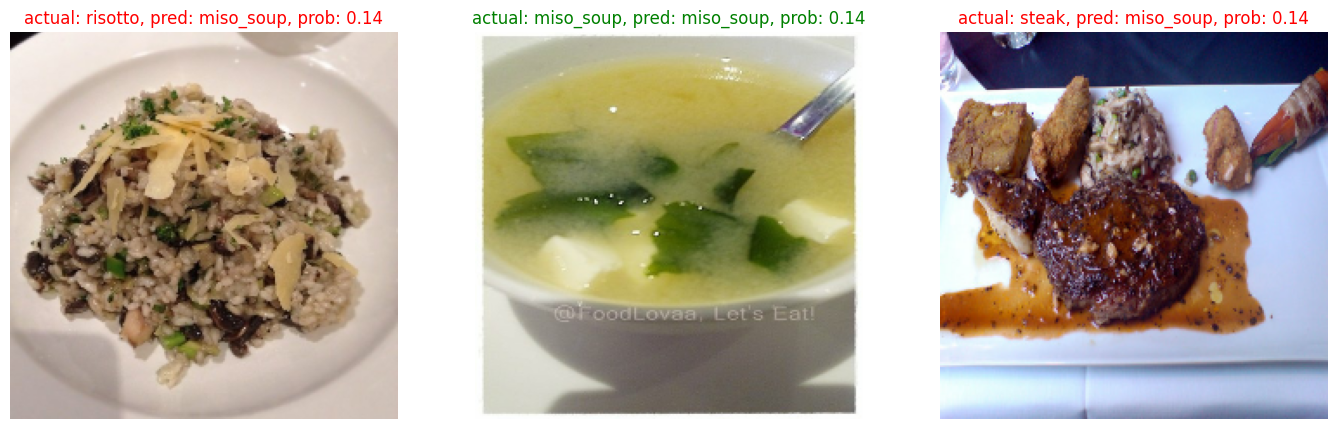

In [57]:
# Make preds on a series of random images
import os
import random
import matplotlib.pyplot as plt


plt.figure(figsize=(17, 10))

for i in range(3):
    # choose a random image(s) from a random class(es)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(f'{test_dir}/{class_name}'))
    filepath = f'{test_dir}/{class_name}/{filename}'
    

    # load the image and make predictions
    img = load_and_prep_image(filepath, scale=True)
    img_expanded = tf.expand_dims(img, axis=0)
    pred_prob = model_loaded.predict(img_expanded) # get predictions probability array
    pred_class = class_names[pred_prob.argmax()] # get highest predictions probability index

    # plot image
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)

    if class_name == pred_class: # if predicted class matches truth class, make test color
        title_color = 'g'
    else:
        title_color = 'r'
    
    plt.title(f'actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
    plt.axis(False)

## Finding the most wrong predictions

To find out where out model is most wrong let's write some code to find out the following:
1. get all the image file paths in the test dataset using list_files() method
2. create a pandas dataframe of the image filepaths, ground truth labels, predicted classes (from our model), max predictions probailities
3. use our dataframe to find all the wrong predictions (where the ground truth label doesn't match the prediction).
4. sort the dataframe based on wrong predictions (we have the highest prediction probability predictions at the top).
5. visualize the image with the highest prediction probabilities but have the wrong prediction.

see: https://www.tensorflow.org/api_docs/python/tf/data/Dataset

In [59]:
# 1. get all the image file path int test dataset
filepaths = []
for filepath in test_data.list_files(f'{test_dir}/*/*.jpg', shuffle=False):
    filepaths.append(filepath.numpy())

filepaths[:10]

[b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1011328.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\101251.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1034399.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\103801.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1038694.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1047447.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1068632.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\110043.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1106961.jpg',
 b'..\\storage\\transfer_learning\\101_food_classes_10_percent\\test\\apple_pie\\1113017.jpg']

In [63]:
# 2. create a pandas dataframe with different parameters for each of our test images
import pandas as pd

dict_data = {
    'img_path': filepaths,
    'y_true': y_labels, 
    'y_pred': pred_classes, 
    'pred_conf': preds_prob.max(axis=1), # get the max values predicted
    'y_true_classname': [class_names[i] for i in y_labels],
    'y_pred_classname': [class_names[i] for i in pred_classes]
}

pred_df = pd.DataFrame(dict_data)

In [64]:
pred_df

img_path  y_true  y_pred  \
0      b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
1      b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
2      b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
3      b'..\\storage\\transfer_learning\\101_food_cla...       0       8   
4      b'..\\storage\\transfer_learning\\101_food_cla...       0       8   
...                                                  ...     ...     ...   
25245  b'..\\storage\\transfer_learning\\101_food_cla...     100     100   
25246  b'..\\storage\\transfer_learning\\101_food_cla...     100      16   
25247  b'..\\storage\\transfer_learning\\101_food_cla...     100     100   
25248  b'..\\storage\\transfer_learning\\101_food_cla...     100     100   
25249  b'..\\storage\\transfer_learning\\101_food_cla...     100     100   

       pred_conf y_true_classname y_pred_classname  
0       0.453735        apple_pie        apple_pie  
1       0.972575        apple_pie        apple_pie  
2       0.627451        apple_pie        apple_pie  
3       0.434676        apple_pie    bread_pudding  
4       0.672471        apple_pie    bread_pudding  
...          ...              ...              ...  
25245   0.969983          waffles          waffles  
25246   0.527392          waffles     cheese_plate  
25247   0.578320          waffles          waffles  
25248   0.238238          waffles          waffles  
25249   0.657321          waffles          waffles  

[25250 rows x 6 columns]

In [65]:
# 3. find out in our dataframe which predictions are wrong
pred_df['pred_correct'] = pred_df['y_true'] == pred_df['y_pred']
pred_df.head()

img_path  y_true  y_pred  \
0  b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
1  b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
2  b'..\\storage\\transfer_learning\\101_food_cla...       0       0   
3  b'..\\storage\\transfer_learning\\101_food_cla...       0       8   
4  b'..\\storage\\transfer_learning\\101_food_cla...       0       8   

   pred_conf y_true_classname y_pred_classname  pred_correct  
0   0.453735        apple_pie        apple_pie          True  
1   0.972575        apple_pie        apple_pie          True  
2   0.627451        apple_pie        apple_pie          True  
3   0.434676        apple_pie    bread_pudding         False  
4   0.672471        apple_pie    bread_pudding         False

In [67]:
# 4. sort our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df['pred_correct'] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
23797  b'..\\storage\\transfer_learning\\101_food_cla...      95      86   
191    b'..\\storage\\transfer_learning\\101_food_cla...       0      31   
15142  b'..\\storage\\transfer_learning\\101_food_cla...      60      64   
18001  b'..\\storage\\transfer_learning\\101_food_cla...      72      67   
11642  b'..\\storage\\transfer_learning\\101_food_cla...      46      10   
17855  b'..\\storage\\transfer_learning\\101_food_cla...      71      65   
23631  b'..\\storage\\transfer_learning\\101_food_cla...      94      83   
10847  b'..\\storage\\transfer_learning\\101_food_cla...      43      68   
10013  b'..\\storage\\transfer_learning\\101_food_cla...      40      43   
17897  b'..\\storage\\transfer_learning\\101_food_cla...      71      65   
7295   b'..\\storage\\transfer_learning\\101_food_cla...      29      31   
11024  b'..\\storage\\transfer_learning\\101_food_cla...      44      70   
5829   b'..\\storage\\transfer_learning\\101_food_cla...      23      68   
8794   b'..\\storage\\transfer_learning\\101_food_cla...      35      41   
14907  b'..\\storage\\transfer_learning\\101_food_cla...      59      76   
9110   b'..\\storage\\transfer_learning\\101_food_cla...      36      31   
18935  b'..\\storage\\transfer_learning\\101_food_cla...      75      33   
10880  b'..\\storage\\transfer_learning\\101_food_cla...      43      68   
22511  b'..\\storage\\transfer_learning\\101_food_cla...      90      78   
17816  b'..\\storage\\transfer_learning\\101_food_cla...      71      70   

       pred_conf      y_true_classname   y_pred_classname  pred_correct  
23797   0.999364                 sushi            sashimi         False  
191     0.998319             apple_pie             donuts         False  
15142   0.997363        lobster_bisque          miso_soup         False  
18001   0.997359              pancakes           omelette         False  
11642   0.997025          garlic_bread         bruschetta         False  
17855   0.996655                paella            mussels         False  
23631   0.996039  strawberry_shortcake    red_velvet_cake         False  
10847   0.995163        fried_calamari        onion_rings         False  
10013   0.994461          french_fries     fried_calamari         False  
17897   0.993322                paella            mussels         False  
7295    0.993167             cup_cakes             donuts         False  
11024   0.992507            fried_rice           pad_thai         False  
5829    0.992440               churros        onion_rings         False  
8794    0.991803             escargots  french_onion_soup         False  
14907   0.991594               lasagna              pizza         False  
9110    0.990882               falafel             donuts         False  
18935   0.989859                   pho            edamame         False  
10880   0.989777        fried_calamari        onion_rings         False  
22511   0.989497   spaghetti_bolognese            poutine         False  
17816   0.989458                paella           pad_thai         False

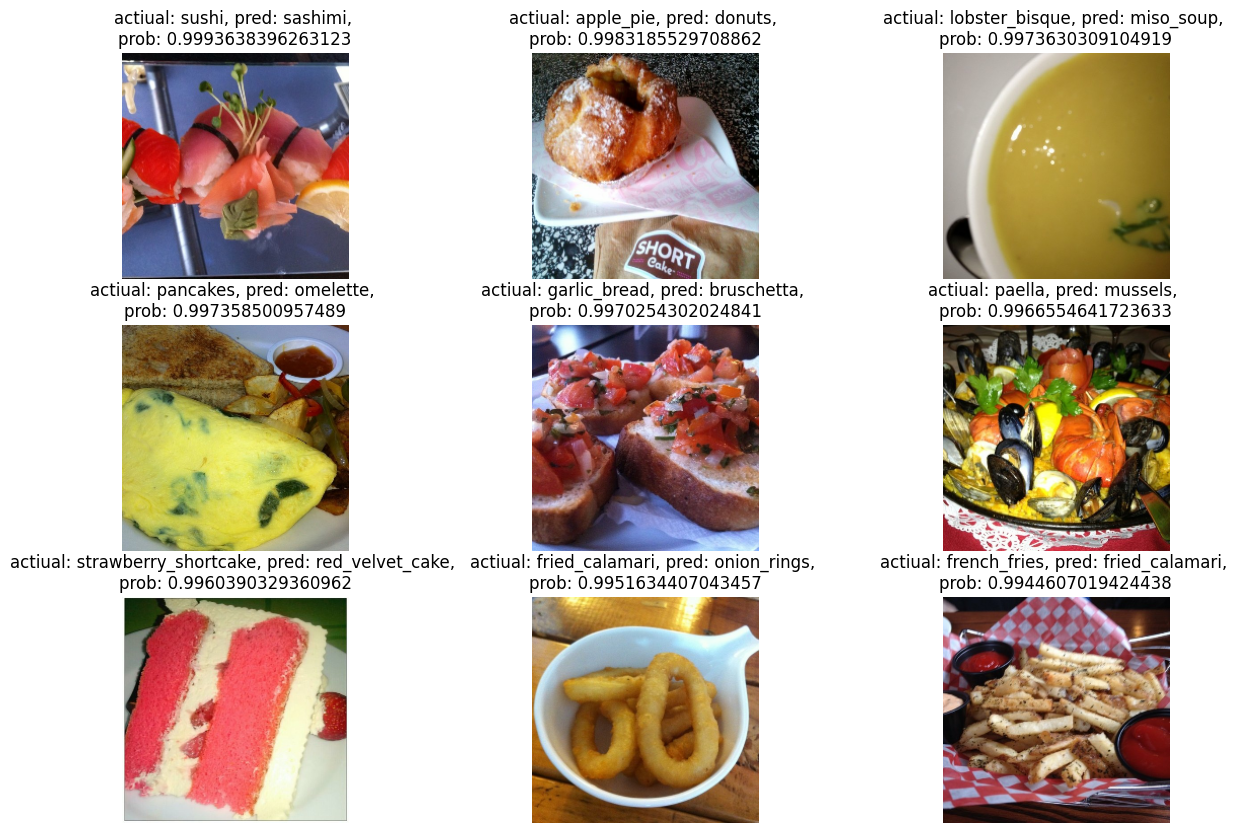

In [90]:
# 5. visualize the best data samples which have the wrong prediction but highest pred probability

image_to_view = 9
start_index = 0

plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index + image_to_view].itertuples()):
    plt.subplot(3, 3, i + 1)
    img = load_and_prep_image(row[1], scale=False)
    # Index, img_path, y_true, y_pred, pred_conf, y_true_classname, y_pred_classname, pred_correct = row, # only interested in a few parameters of each row
    
    plt.imshow(img/255.)
    plt.title(f'actiual: {row[5]}, pred: {row[6]}, \nprob: {row[4]}')
    plt.axis(False)

In [97]:
filename = 'custom_food_images.zip'
folder = filename.split('.')[0]
url = f'https://storage.googleapis.com/ztm_tf_course/food_vision/{filename}'

In [98]:
unzip_data(url, filename, ZIP_PATH, TRANSFER_LEARNING_PATH)

In [101]:
custom_food_images = [f'{TRANSFER_LEARNING_PATH}/custom_food_images/' + img_path for img_path in os.listdir(f'{TRANSFER_LEARNING_PATH}/custom_food_images/')]
custom_food_images

['..\\storage/transfer_learning/custom_food_images/chicken_wings.jpeg',
 '..\\storage/transfer_learning/custom_food_images/hamburger.jpeg',
 '..\\storage/transfer_learning/custom_food_images/pizza-dad.jpeg',
 '..\\storage/transfer_learning/custom_food_images/ramen.jpeg',
 '..\\storage/transfer_learning/custom_food_images/steak.jpeg',
 '..\\storage/transfer_learning/custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 31ms/step


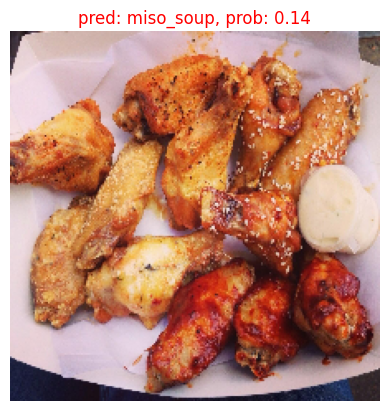

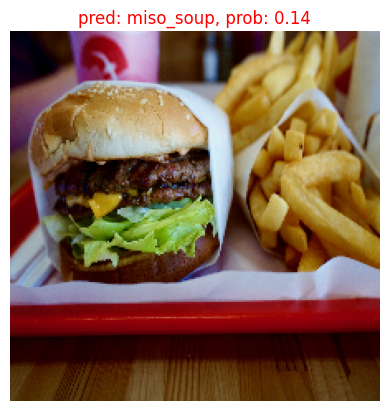

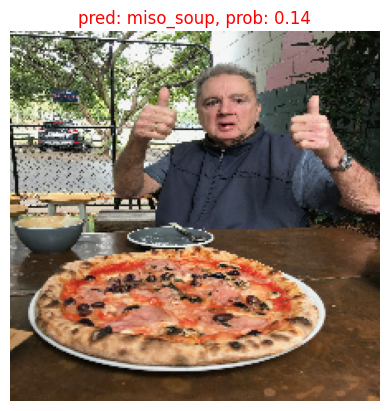

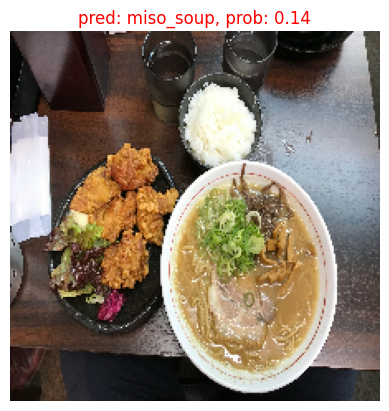

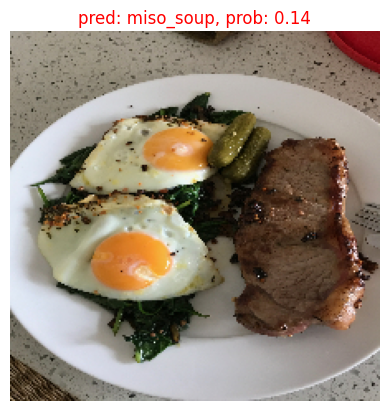

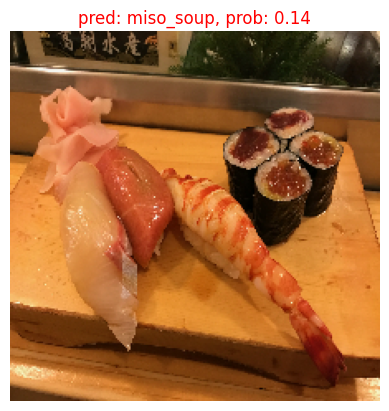

In [116]:
# make predictions on and plot custom images
for img in custom_food_images:
    image = load_and_prep_image(img, scale=False) # don't need scale for EfficientNetB0
    pred_prod = model_loaded.predict(tf.expand_dims(image, axis=0)) # make predictions
    pred_class = class_names[pred_prob.argmax()] # get the index with the highest prediction probability

    
    # plot image
    plt.figure()
    plt.imshow(image/255.)

    if class_name == pred_class: # if predicted class matches truth class, make test color
        title_color = 'g'
    else:
        title_color = 'r'
    
    plt.title(f'pred: {pred_class}, prob: {pred_prob.max():.2f}', c=title_color)
    plt.axis(False)